In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import operator

# Fault Condition 1 is for a variable air volume (VAV) fans with variable speed drives (VFD) that control to pressurizing the duct system to a duct "static" pressure setpoint. The fan data will be in units of % which is the VFD speed command or signal from the PID controller and the duct pressure sensor data and setpoint shown in this demo is in impoerial units of Inches Water Column

Schematic below is from this blog about HVAC: https://www.hvacbrain.com/blog/vav-versus-vvt/

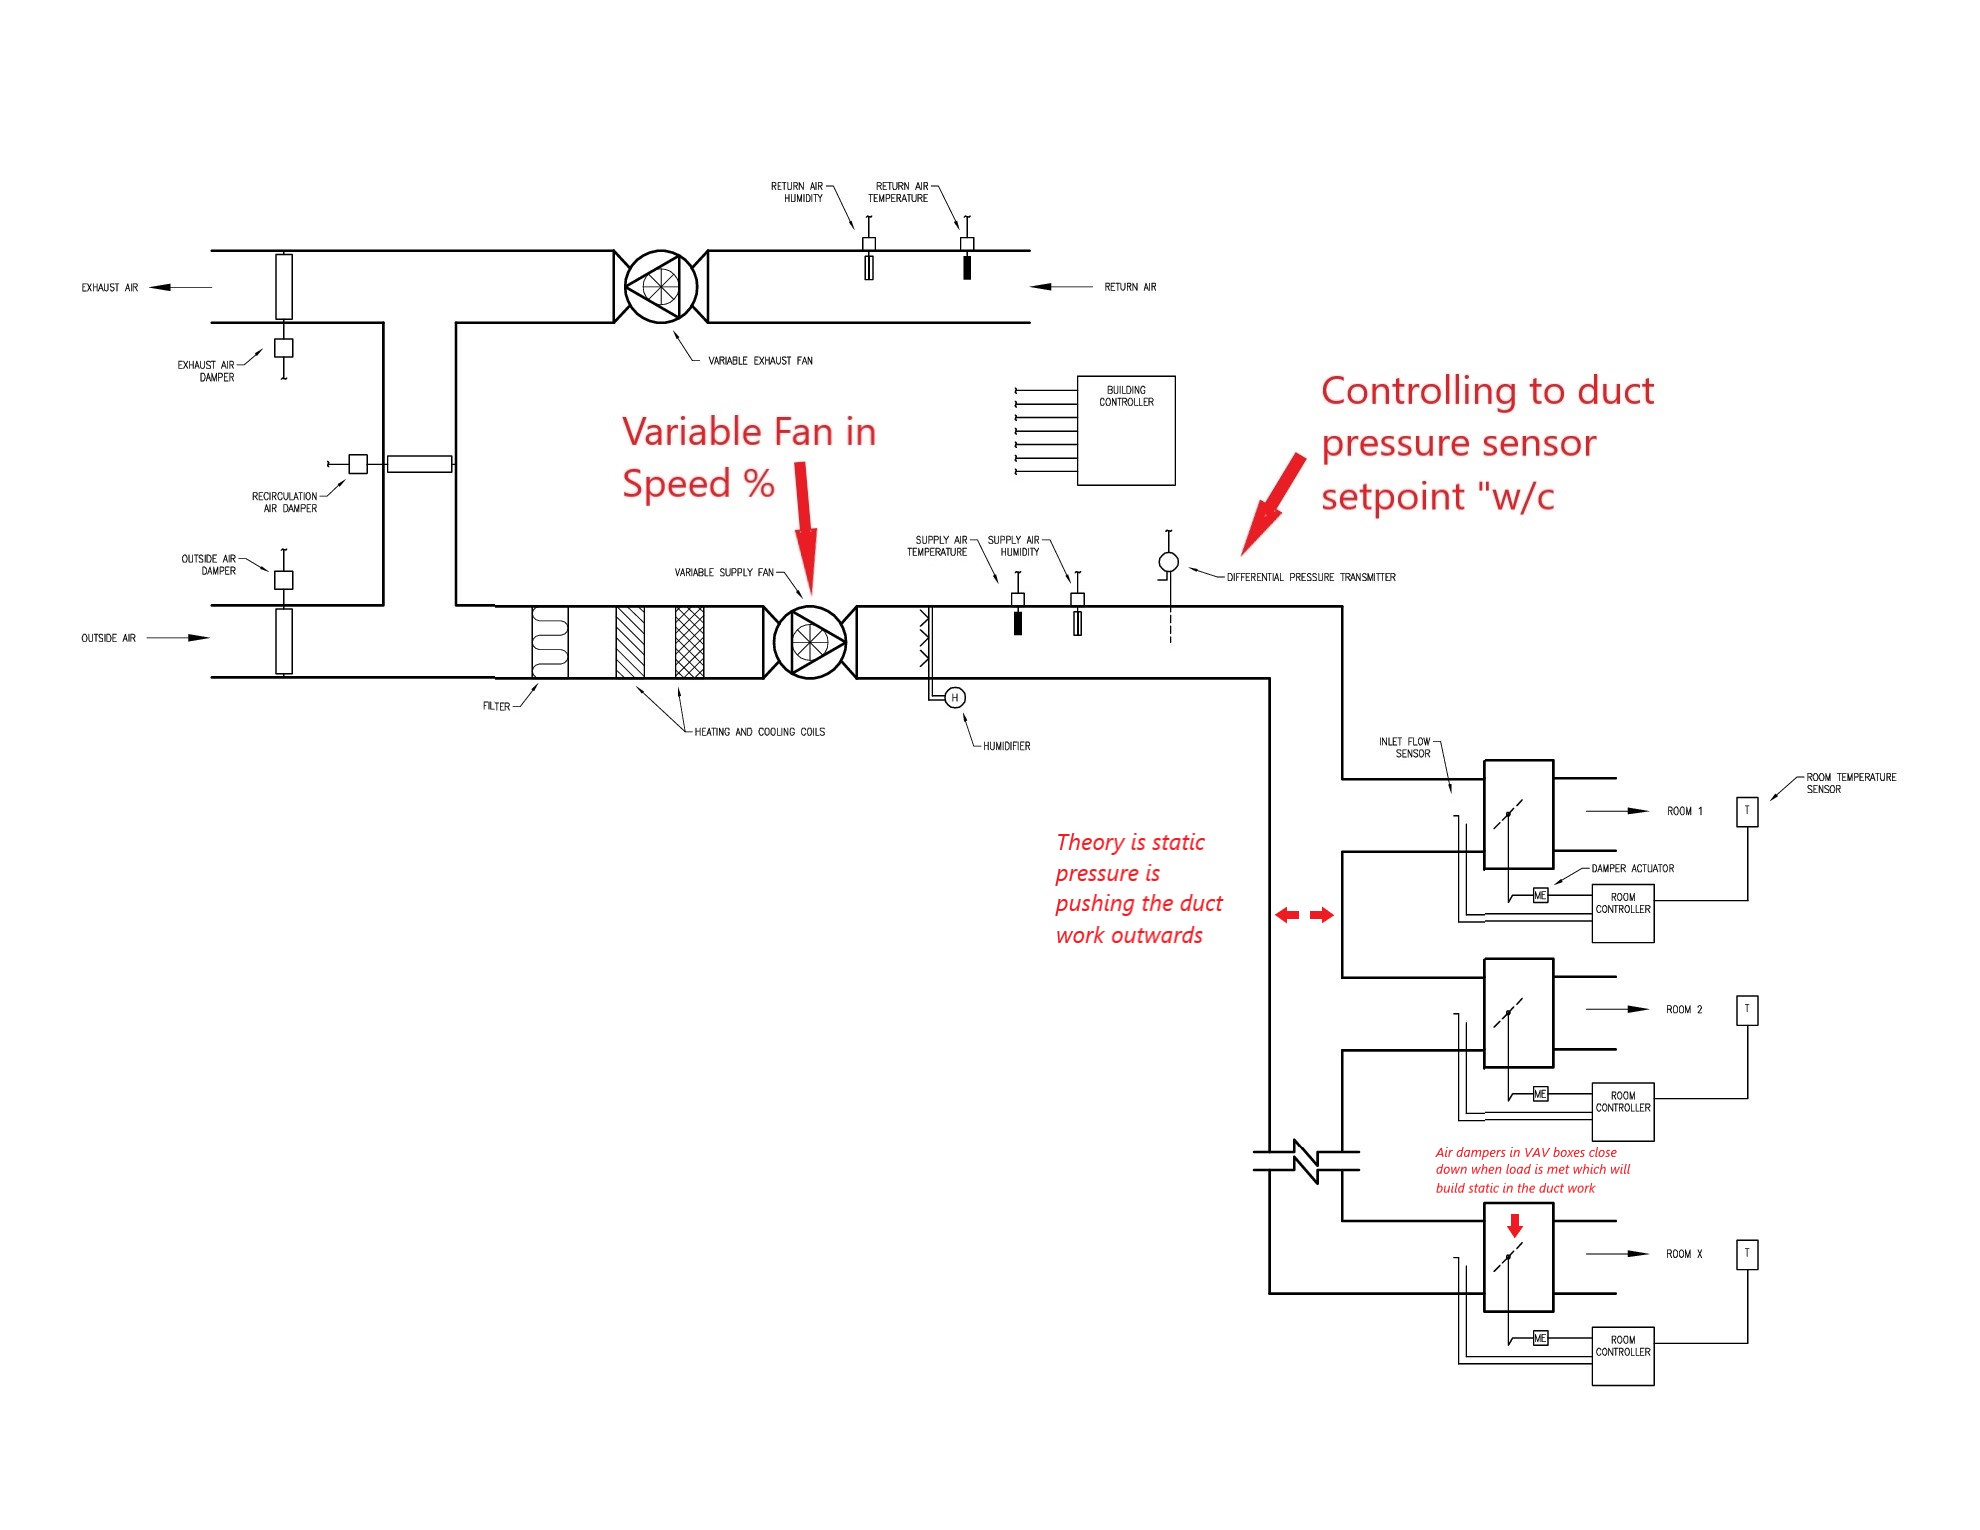

# This measure applies to all "MODES" for AHU. I.E., heating, cooling, economizer, etc. Defined as a OS#

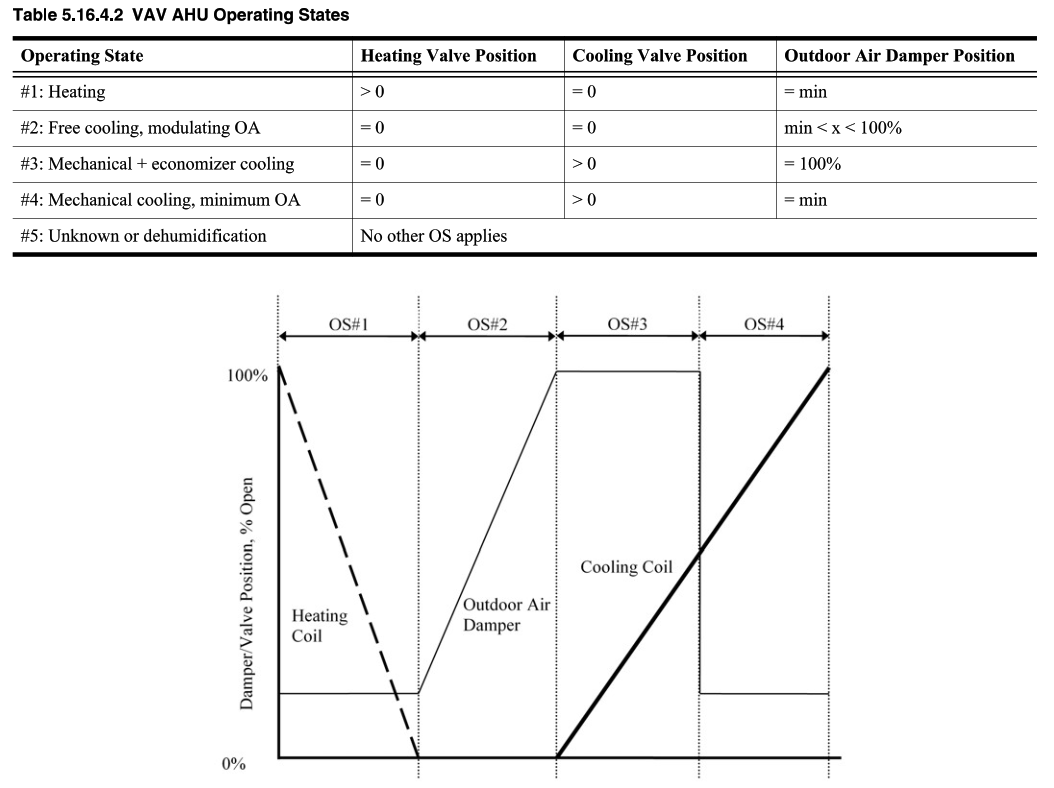

* This image above denotes a heating mode, economizer mode, economizer + mechanical cooling, and mechanical cooling only moving left to right based on the data coming from the heating valve, outside air damper, and cooling.

# Snip of ASHRAE Fault Condition 1 definition related to AHU Fan Speed and Duct Pressure Control

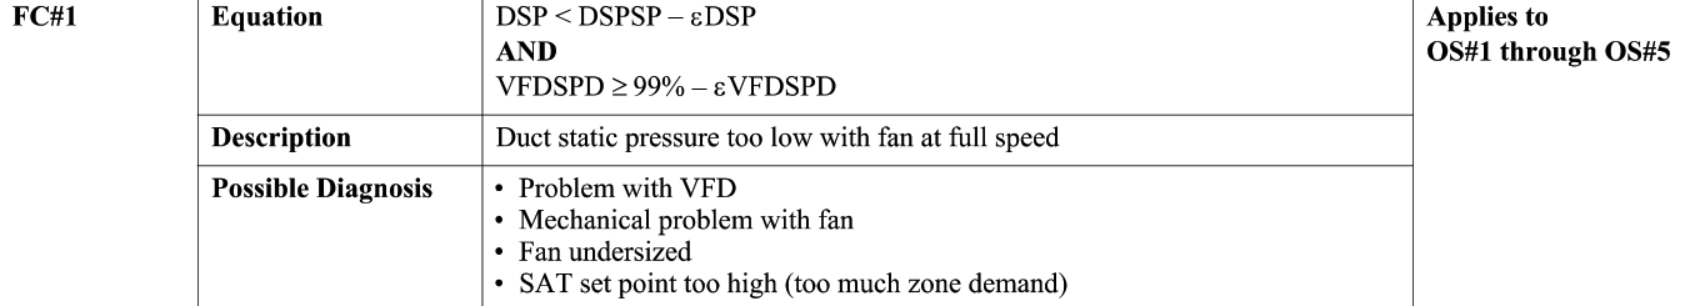

In [2]:
# Equation returns Boolean True Or False

def fault_condition_one(dataframe):
    return operator.and_(dataframe.duct_static < dataframe.duct_static_setpoint, dataframe.vfd_speed >= dataframe.vfd_speed_percent_max - dataframe.vfd_speed_percent_err_thres)


# Read Associated CSV files forward fill dataset and remove NaNs

In [3]:
rtu_duct_pressure = pd.read_csv('./summer_data/RTU Duct Static Pressure-data-as-seriestocolumns-2021-11-06 07_21_53.csv', index_col='Time', parse_dates=True).fillna(method='ffill').dropna()
rtu_fan_speed = pd.read_csv('./summer_data/RTU Supply Fan Speed-data-2021-11-05 12_06_04.csv', index_col='Time', parse_dates=True).fillna(method='ffill').dropna()


# Compute 5 Min Rolling Avg Per G36 Spec

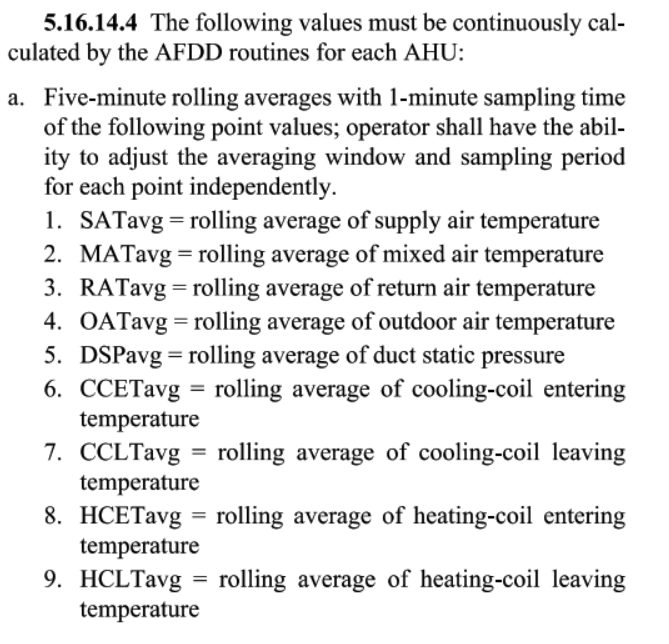

In [4]:
rtu_duct_pressure_avg = rtu_duct_pressure.rolling('5T').mean()
rtu_fan_speed_avg = rtu_fan_speed.rolling('5T').mean()

In [5]:
# combine duct pressure and fan speed datasets
fc1_dataset = rtu_duct_pressure_avg.join(rtu_fan_speed_avg)

In [6]:
# rename columns
fc1_dataset.rename(columns={'slipstream_internal/slipstream_hq/1100/Duct Static Pressure Local': 'duct_static', 
                   'slipstream_internal/slipstream_hq/1100/Duct Static Pressure Setpoint Active': 'duct_static_setpoint',
                   'slipstream_internal/slipstream_hq/1100/Supply Fan Speed Command': 'vfd_speed'}, inplace=True)

In [7]:
fc1_dataset.columns

Index(['duct_static', 'duct_static_setpoint', 'vfd_speed'], dtype='object')

In [8]:
# small dataset logged from VOLTTRON on 1 min intervals.
# Its about 3 days of data which was the max my
# web browser could handle retrieving the data
# via grafana interface

fc1_dataset.describe()

,duct_static,duct_static_setpoint,vfd_speed
count,7194.000000,7194.000000,7194.00000
mean,0.436413,0.852446,43.02393
std,0.451094,0.120657,45.85417
min,0.027540,0.750000,0.00000
25%,0.032000,0.750000,0.00000
50%,0.033100,0.750000,0.00000
75%,0.962800,1.000000,90.53000
max,1.542000,1.000000,100.00000


# Plot data for visulation 

array([<AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>], dtype=object)

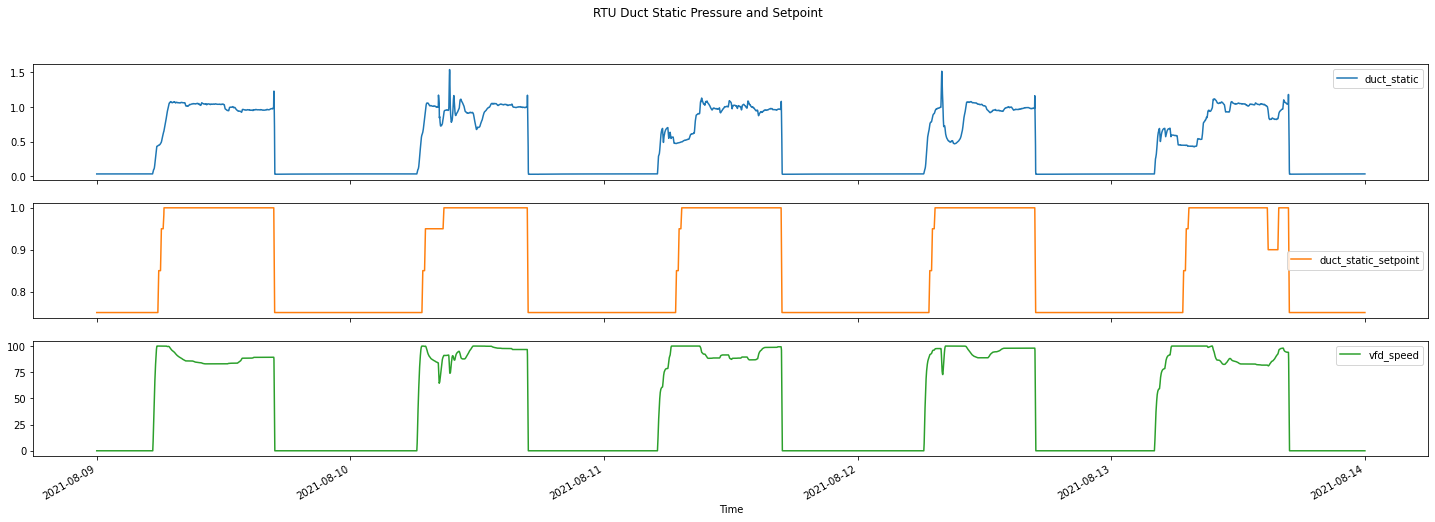

In [9]:
fc1_dataset.plot(figsize=(25,8), subplots=True, title='RTU Duct Static Pressure and Setpoint')

# Set Internal Variables per G36 Spec Imperial Units

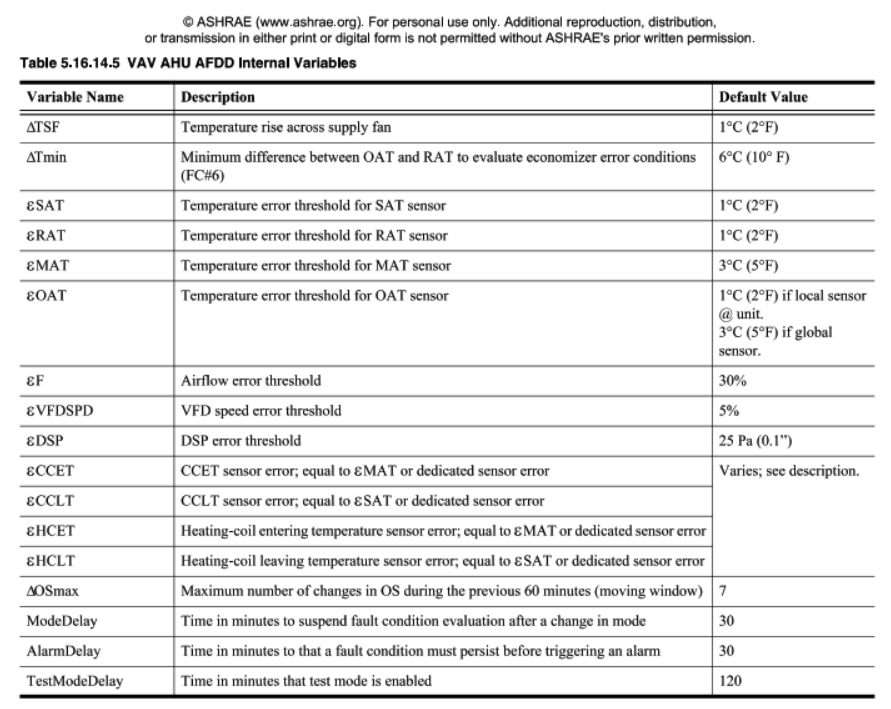

In [10]:
supply_fan_delta_degf = 2
oat_rat_delta_degf_min = 10
supply_degf_err_thres = 2
return_degf_err_thres = 2
mix_degf_err_thres = 5
outdoor_degf_err_thres = 5
air_flow_percent_thres = .3
vfd_speed_percent_err_thres = .05
vfd_speed_percent_max = .99
duct_static_inches_err_thres = .1
delta_os_max = 7
mode_delay = 30
alarm_dely = 30
test_mode_delay = 120 

In [11]:
# make an entire column out of these params in the Pandas Dataframe
fc1_dataset['vfd_speed_percent_err_thres'] = vfd_speed_percent_err_thres
fc1_dataset['duct_static_inches_err_thres'] = duct_static_inches_err_thres
fc1_dataset['vfd_speed_percent_max'] = vfd_speed_percent_max

In [12]:
fc1_dataset.columns

Index(['duct_static', 'duct_static_setpoint', 'vfd_speed',
       'vfd_speed_percent_err_thres', 'duct_static_inches_err_thres',
       'vfd_speed_percent_max'],
      dtype='object')

# Run dataset through the function we created in cell 2 that will attempt to FLAG some faults!

In [13]:
fc1_dataset['fc1_flag'] = fault_condition_one(fc1_dataset)

In [14]:
fc1_dataset.head()

,duct_static,duct_static_setpoint,vfd_speed,vfd_speed_percent_err_thres,duct_static_inches_err_thres,vfd_speed_percent_max,fc1_flag
Time,,,,,,,
2021-08-09 00:00:01,0.03250,0.75,0.0,0.05,0.1,0.99,False
2021-08-09 00:01:01,0.03260,0.75,0.0,0.05,0.1,0.99,False
2021-08-09 00:02:01,0.03270,0.75,0.0,0.05,0.1,0.99,False
2021-08-09 00:03:01,0.03265,0.75,0.0,0.05,0.1,0.99,False
2021-08-09 00:04:01,0.03274,0.75,0.0,0.05,0.1,0.99,False


In [15]:
# check True and False counts

fc1_dataset['fc1_flag'].value_counts()

False    5025
True     2169
Name: fc1_flag, dtype: int64

* Nice to see there is mix of True and False. If ALL data is either False or True, something may not be correct in fault detection else the mechanical system is running perfectly which can be rare : )

In [16]:
# change boolean column to int for plots

fc1_dataset['fc1_flag'] = fc1_dataset['fc1_flag'].astype(int)

# drop params column for better plot
fc1_dataset = fc1_dataset.drop(['vfd_speed_percent_err_thres',
                  'duct_static_inches_err_thres',
                  'vfd_speed_percent_max'],axis=1)


https://stackoverflow.com/questions/69900456/pandas-compute-time-delta-on-filtered-datasets

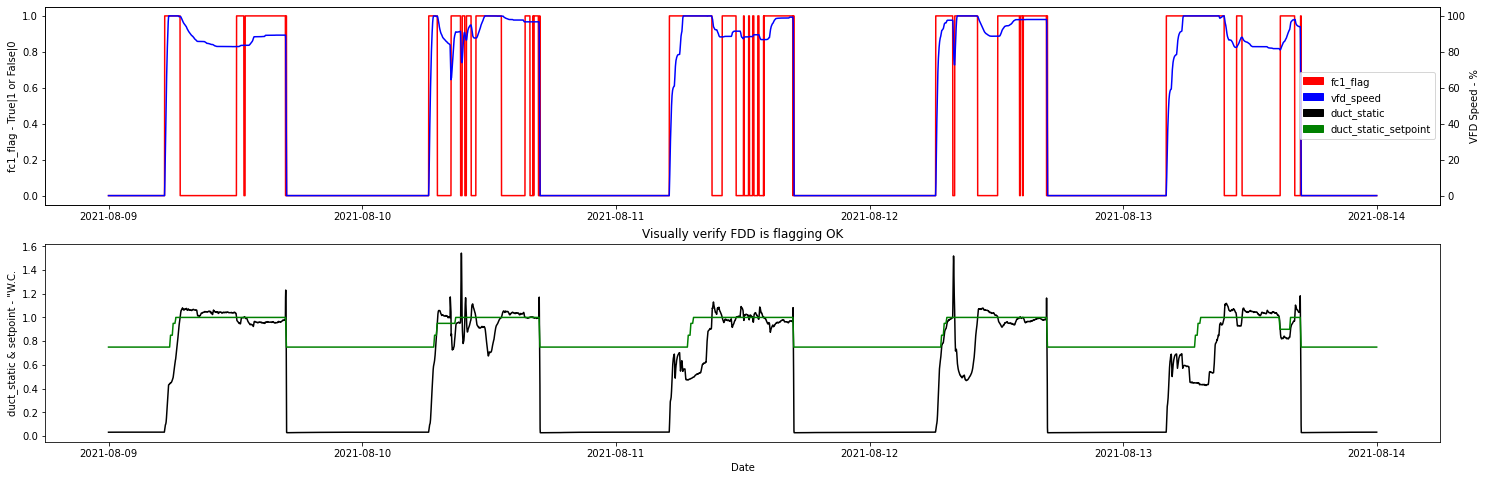

In [17]:
fc1_dataset[['fc1_flag','duct_static','duct_static_setpoint','vfd_speed']].loc['2021-8-9'].between_time('5:00', '17:00')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25,8))
plt.title('Visually verify FDD is flagging OK')
 
ax1b = ax1.twinx()    
plot1a, = ax1.plot(fc1_dataset.index, fc1_dataset.fc1_flag, color='r') # red
plot1b, = ax1b.plot(fc1_dataset.index, fc1_dataset.vfd_speed, color='b') # blue
ax1.set_ylabel('fc1_flag - True|1 or False|0')
ax1b.set_ylabel('VFD Speed - %')


ax2.plot(fc1_dataset.index, fc1_dataset.duct_static, color='k') # black
ax2.plot(fc1_dataset.index, fc1_dataset.duct_static_setpoint, color='g') # green
ax2.set_xlabel('Date')
ax2.set_ylabel('duct_static & setpoint - "W.C.')


red_patch = mpatches.Patch(color='red', label='fc1_flag')
blue_patch = mpatches.Patch(color='blue', label='vfd_speed')
black_patch = mpatches.Patch(color='black', label='duct_static')
green_patch = mpatches.Patch(color='green', label='duct_static_setpoint')
plt.legend(handles=[red_patch,blue_patch,black_patch,green_patch])


# show plot
plt.show()

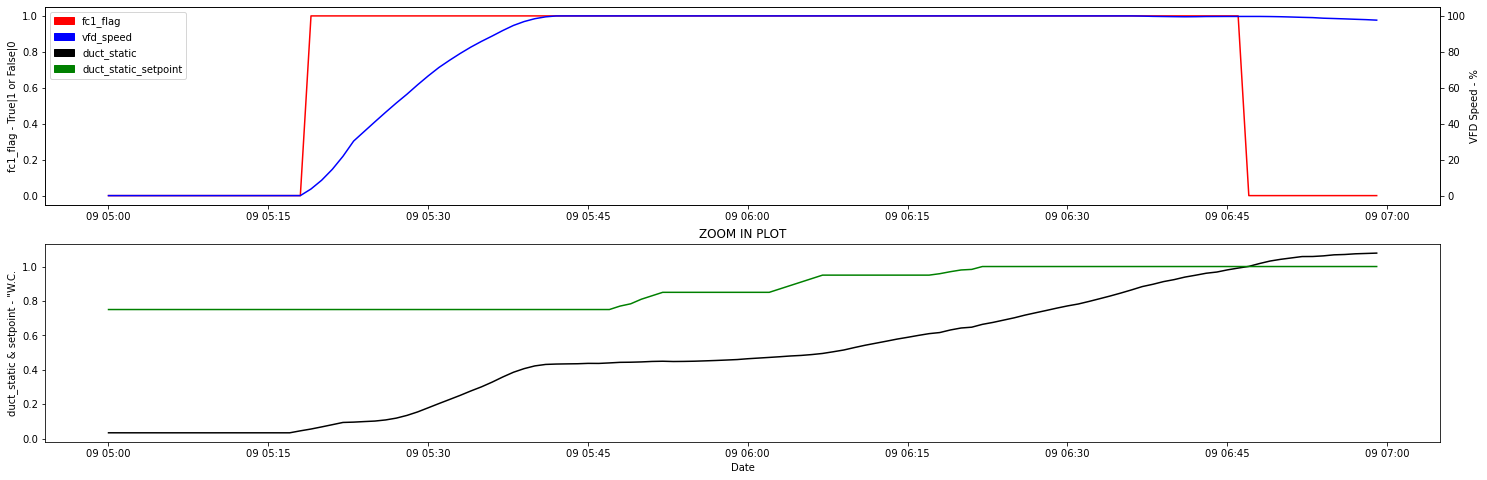

In [18]:
# Lets ZOOM in on a day to get a closure look

zoom_plot = fc1_dataset[['fc1_flag','duct_static','duct_static_setpoint','vfd_speed']].loc['2021-8-9'].between_time('5:00', '7:00')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25,8))
plt.title('ZOOM IN PLOT')
 
ax1b = ax1.twinx()    
plot1a, = ax1.plot(zoom_plot.index, zoom_plot.fc1_flag, color='r') # red
plot1b, = ax1b.plot(zoom_plot.index, zoom_plot.vfd_speed, color='b') # blue
ax1.set_ylabel('fc1_flag - True|1 or False|0')
ax1b.set_ylabel('VFD Speed - %')


ax2.plot(zoom_plot.index, zoom_plot.duct_static, color='k') # black
ax2.plot(zoom_plot.index, zoom_plot.duct_static_setpoint, color='g') # green
ax2.set_xlabel('Date')
ax2.set_ylabel('duct_static & setpoint - "W.C.')


red_patch = mpatches.Patch(color='red', label='fc1_flag')
blue_patch = mpatches.Patch(color='blue', label='vfd_speed')
black_patch = mpatches.Patch(color='black', label='duct_static')
green_patch = mpatches.Patch(color='green', label='duct_static_setpoint')
plt.legend(handles=[red_patch,blue_patch,black_patch,green_patch])


# show plot
plt.show()

# The Fault Flag seems like its working!

* The RED line shown above in the ZOOM IN PLOT is the Fault Flag where according the G36 equation, we flag TRUE when the fan is running at near max capacity (Blue Line) and the duct system cannot make static pressure setpoint (Black and Green Lines).

# The second D in FDD is "Diagnostics"

Let's get creative : )

* Calculate percent TRUE AND FALSE of FDD Flag

In [19]:
percent_true = fc1_dataset.fc1_flag.mean()

print("Percent of time in the dataset when FLAG is True")

percent_true

Percent of time in the dataset when FLAG is True


0.30150125104253545

In [20]:
percent_false = 1 - percent_true

print("Percent of time in the dataset when FLAG is False")

percent_false

Percent of time in the dataset when FLAG is False


0.6984987489574646

# Calculate elapsed time for fault conditions True

https://stackoverflow.com/questions/69900456/pandas-compute-time-delta-on-filtered-datasets/69900606?noredirect=1#comment123564435_69900606

In [21]:
# Compute time in hours for ALL data
fc1_dataset["timedelta_alldata"] = fc1_dataset.index.to_series().diff()

print("TOTAL TIME FOR ENTIRE DATASET")

fc1_dataset.timedelta_alldata.sum()

TOTAL TIME FOR ENTIRE DATASET


Timedelta('4 days 23:59:00')

https://www.kite.com/python/answers/how-to-convert-a-timedelta-to-days,-hours,-and-minutes-in-python

In [22]:
seconds_alldata = fc1_dataset.timedelta_alldata.sum().seconds
days_alldata = fc1_dataset.timedelta_alldata.sum().days

hours_alldata = seconds_alldata//3600
minutes_alldata = (seconds_alldata//60)%60

total_hours_calc = days_alldata * 24 + hours_alldata

print("Dataset Total Hour Calc:", total_hours_calc)

Dataset Total Hour Calc: 119


In [23]:
fc1_dataset["timedelta_fddflag"] = fc1_dataset.index.to_series().diff().where(fc1_dataset["fc1_flag"] == 1)

print("TOTAL TIME FOR WHEN FDD FLAG is TRUE")

fc1_dataset.timedelta_fddflag.sum()

TOTAL TIME FOR WHEN FDD FLAG is TRUE


Timedelta('1 days 12:09:02')

In [24]:
seconds_flagdata = fc1_dataset.timedelta_fddflag.sum().seconds
days_flagdata = fc1_dataset.timedelta_fddflag.sum().days

hours_flagdata = seconds_flagdata//3600
minutes_flagdata = (seconds_flagdata//60)%60

flag_hours_calc = days_flagdata * 24 + hours_flagdata

print("Flagged FDD Data Total Hour Calc:", flag_hours_calc)

Flagged FDD Data Total Hour Calc: 36


# Plot on histogram the hour-of-day when the FDD "FLAG" is TRUE

<AxesSubplot:title={'center':'Hour Of Day When Flag is TRUE'}, ylabel='Frequency'>

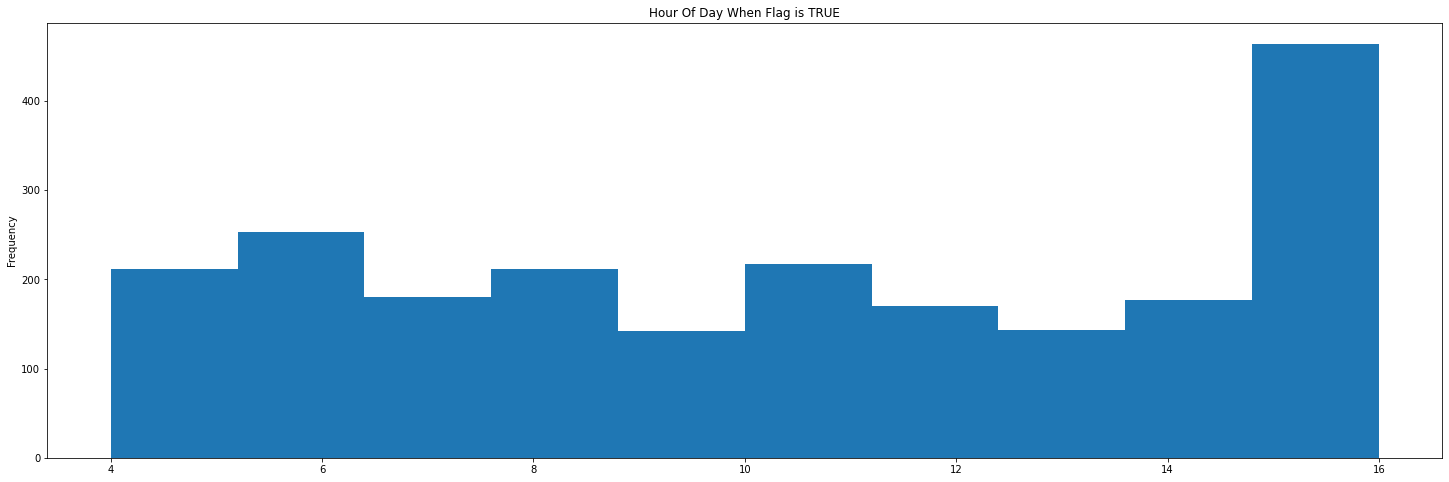

In [25]:
fc1_dataset['hour_of_the_day'] = fc1_dataset.index.hour.where(fc1_dataset["fc1_flag"] == 1)

fc1_dataset.hour_of_the_day.plot.hist(title='Hour Of Day When Flag is TRUE',figsize=(25,8))

# Compute duct pressure deviation from setpoint or error

In [26]:
print("Duct Pressure Average for dataset when FLAG IS TRUE")

print("Units in Inches Water Column: ",round(fc1_dataset.duct_static.where(fc1_dataset["fc1_flag"] == 1).mean(),2))

Duct Pressure Average for dataset when FLAG IS TRUE
Units in Inches Water Column:  0.79


In [27]:
print("Duct Pressure Average Error for dataset when FLAG IS TRUE")


error_from_setpoint = fc1_dataset.duct_static_setpoint.where(fc1_dataset["fc1_flag"] == 1).mean() - fc1_dataset.duct_static.where(fc1_dataset["fc1_flag"] == 1).mean()
print("Units in Inches Water Column: ",round(error_from_setpoint,2))

Duct Pressure Average Error for dataset when FLAG IS TRUE
Units in Inches Water Column:  0.16


# What else would be interesting to see in FDD Diagnostics? Post a git issue for look me up in the repo contact info